# Preparazione

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=d875cb17c73c0af71dde9dcd402ce13e44a0476aa0a553d5925aff2008c7dd8e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=1eef2475ab1ab7961c9f139b1be3db2ca7489b35ba44f5493beff65d9a37dadb
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [3]:
!ngrok authtoken 2Tn9uykXlYRjLcSLIgmv1iLdEvG_3gqA9M3V4hLGqH9N3JWEr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [30]:
from pyngrok import ngrok
import re
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as sqlf
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [6]:
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("VideogameRecommenderSystem").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [7]:
port = '4050'
public_url = ngrok.connect(port).public_url

In [8]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://e874-34-82-241-75.ngrok-free.app" -> "http://127.0.0.1:4050"


In [9]:
spark

In [10]:
# Connect this colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utils

In [11]:
CLEANER_LINKS = re.compile('http[s]?://\S+')

def clean_links(raw_text):
  cleantext = re.sub(CLEANER_LINKS, '', raw_text)
  return cleantext

clean_links_UDF = sqlf.udf(lambda x : clean_links(x), StringType())

In [12]:
CLEANER_PUNCTUATION = re.compile('[^\w\s]')

def clean_punctuation(raw_text):
  cleantext = re.sub(CLEANER_PUNCTUATION, ' ', raw_text)
  return cleantext

clean_punctuation_UDF = sqlf.udf(lambda x : clean_punctuation(x), StringType())

In [13]:
CLEANER_EXTRA_SPACES = re.compile('\s\s+')

def clean_extra_spaces(raw_text):
  cleantext = re.sub(CLEANER_EXTRA_SPACES, ' ', raw_text)
  return cleantext

clean_extra_spaces_UDF = sqlf.udf(lambda x : clean_extra_spaces(x), StringType())

In [14]:
@sqlf.udf("long")
def num_nonzeros(v):
  return v.numNonzeros()

In [15]:
def process_data_for_clustering(dataset_df,
                                column_name):
  dataset_df = dataset_df.dropna()
  dataset_df = dataset_df.withColumn(column_name, clean_links_UDF(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, sqlf.trim(sqlf.col(column_name)))

  dataset_df = dataset_df.where(dataset_df.total_recommendations > 0)

  dataset_df = dataset_df.withColumn(column_name, sqlf.lower(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, clean_punctuation_UDF(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, clean_extra_spaces_UDF(sqlf.col(column_name)))

  tokenizer = Tokenizer(inputCol=column_name, outputCol='tokens')
  tokens_df = tokenizer.transform(dataset_df)

  stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='terms')
  terms_df = stopwords_remover.transform(tokens_df)

  stemmer = SnowballStemmer(language="english")
  stemmer_udf = sqlf.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
  terms_stemmed_df = terms_df.withColumn('terms_stemmed', stemmer_udf('terms'))

  cv = CountVectorizer(inputCol='terms_stemmed', outputCol="tf_features", vocabSize=1000, minDF=10)
  idf = IDF(inputCol="tf_features", outputCol="features")

  pipeline = Pipeline(stages=[cv, idf])
  features = pipeline.fit(terms_stemmed_df)
  tf_idf_df = features.transform(terms_stemmed_df)

  tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

  return tf_idf_df

In [16]:
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="cosine",
                     prediction_col="cluster"
                     ):

  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [17]:
def compute_PCA(dataset_df,
                input_col='features_norm',
                output_col='pca_features',
                num_components=2
                ):
  pca = PCA(k=num_components, inputCol=input_col, outputCol=output_col)
  pca_model = pca.fit(dataset_df)
  pca_result = pca_model.transform(dataset_df)
  return pca_result

In [18]:
def scatter_cluster(pca_pd,
                    k,
                    n_col):
  colors = np.random.rand(k, 3)

  pca_pd[['pca_1', 'pca_2']] = pca_pd['pca_features'].apply(lambda x: pd.Series(x))
  plt.figure(figsize=(8, 6))
  for cluster_id in range(k):
      cluster_data = pca_pd[pca_pd['cluster'] == cluster_id][['pca_1', 'pca_2']]
      plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster_id}', color=colors[cluster_id])

  plt.title('TF-IDF KMeans Clustering')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=n_col)
  plt.show()

# Games clustered on 'about_the_game'

In [19]:
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [20]:
tf_idf_about_df = process_data_for_clustering(games_df, 'about_the_game')

In [21]:
tf_idf_about_df = Normalizer(inputCol='features', outputCol='features_norm', p=1).transform(tf_idf_about_df)

In [22]:
cluster_about = KMeansModel.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/models/KMEANS_about_K_50')

In [23]:
clusters_about_df = cluster_about.transform(tf_idf_about_df)

In [24]:
del games_df
gc.collect()

524

In [25]:
shilouette = evaluate_k_means(clusters_about_df)
print('The shilouette score, computed with the cosine distance, is: {:.3f}'.format(shilouette))

The shilouette score, computed with the cosine distance, is: 0.045


In [26]:
clusters_about_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|  585|
|      1|  171|
|      2|  743|
|      3|  106|
|      4|  539|
|      5|  325|
|      6|  133|
|      7|  723|
|      8|   89|
|      9|  345|
|     10|  310|
|     11|   46|
|     12|   63|
|     13|  240|
|     14|  124|
|     15|  530|
|     16|  228|
|     17|  129|
|     18|  196|
|     19|  814|
+-------+-----+
only showing top 20 rows



In [27]:
pca_df = compute_PCA(clusters_about_df)

In [28]:
pca_pd = pca_df.toPandas()

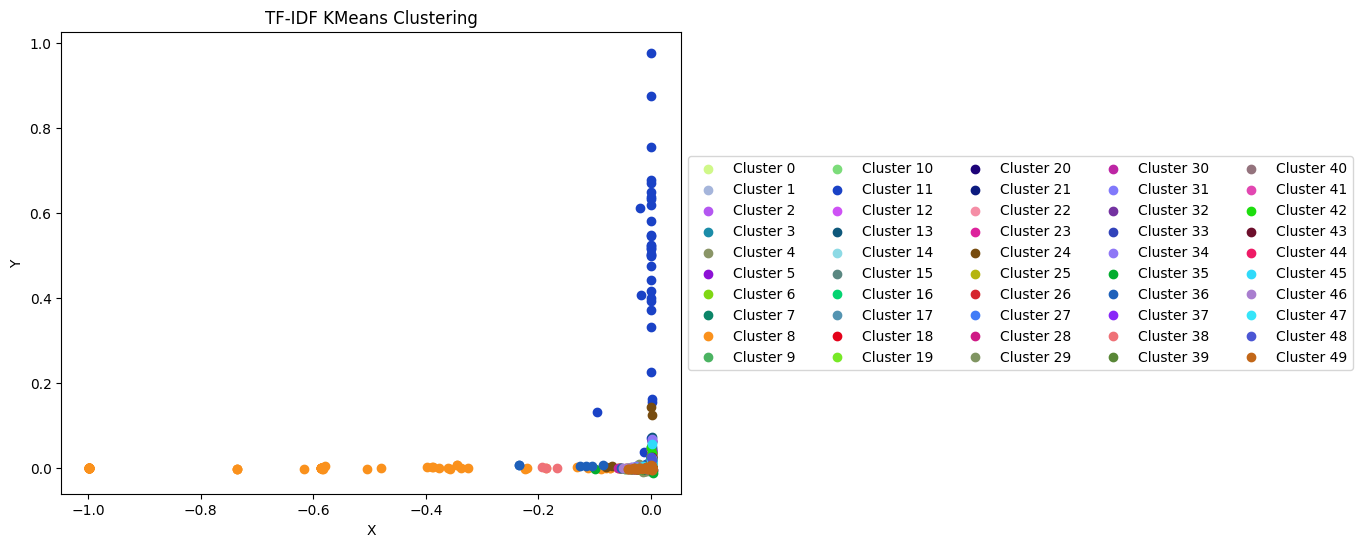

In [31]:
# Create a scatter plot
scatter_cluster(pca_pd, 50, 5)

# Games clustered on short_description

In [ ]:
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
g_tmp = games_df.where(games_df.total_recommendations > 0)

In [ ]:
top_100_distinct_values = g_tmp.groupBy('steam_appid').count().orderBy(sqlf.col("count").desc()).limit(100)

In [ ]:
demo_game_df = g_tmp.join(top_100_distinct_values, on='steam_appid', how="inner")

In [ ]:
demo_game_df.write.options(header='True', delimiter=',').csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/demo_game_cluster_data')

In [ ]:
tf_idf_short_df = process_data_for_clustering(games_df, 'short_description')

In [ ]:
tf_idf_short_df = Normalizer(inputCol='features', outputCol='features_norm', p=1).transform(tf_idf_short_df)

In [ ]:
cluster_short = KMeansModel.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/models/KMEANS_short_K_300')

In [ ]:
clusters_short_df = cluster_short.transform(tf_idf_short_df)

In [ ]:
clusters_short_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- total_recommendations: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- terms_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- cluster: integer (nullable = false)



In [ ]:
tmp = clusters_short_df.drop('about_the_game', 'total_recommendations', 'tokens', 'terms', 'terms_stemmed', 'tf_features', 'features', 'features_norm')

In [ ]:
tmp.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- cluster: integer (nullable = false)



In [ ]:
tmp.write.options(header='True', delimiter=',').csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/demo_cluster')

In [ ]:
del games_df
gc.collect()

556

In [ ]:
shilouette = evaluate_k_means(clusters_short_df)
print('The shilouette score, computed with the cosine distance, is: {:.3f}'.format(shilouette))

The shilouette score, computed with the cosine distance, is: 0.057


In [ ]:
clusters_short_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|   33|
|      1|   58|
|      2|   25|
|      3|   78|
|      4|   59|
|      5|   24|
|      6|   37|
|      7|   70|
|      8|   48|
|      9|  116|
|     10|   48|
|     11|   71|
|     12|   58|
|     13|   52|
|     14|   38|
|     15|   65|
|     16|  108|
|     17|  136|
|     18|   46|
|     19|   62|
+-------+-----+
only showing top 20 rows



In [ ]:
pca_df = compute_PCA(clusters_short_df)

In [ ]:
pca_pd = pca_df.toPandas()

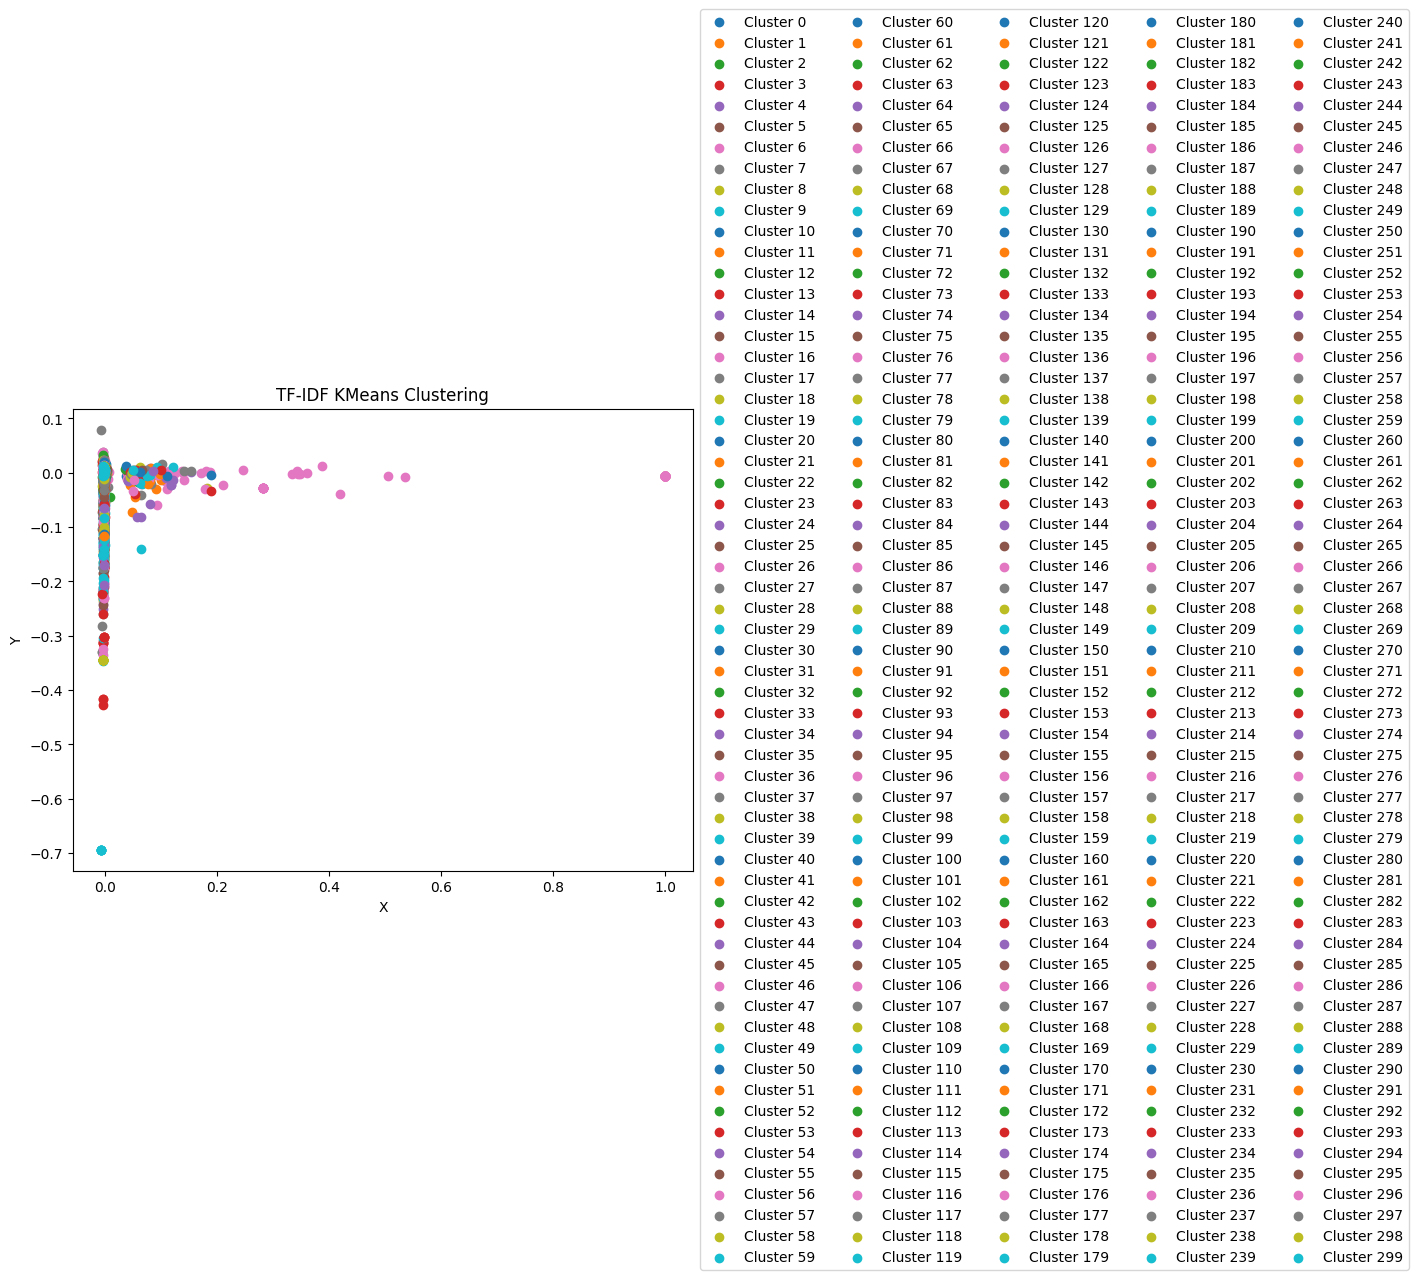

In [ ]:
# Create a scatter plot
scatter_cluster(pca_pd, 300, 5)